# Descriptive Analytics

## Data Overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from h3 import h3 
from shapely.geometry import shape
from shapely.geometry import Point

In [2]:
df=pd.read_csv('taxi_2017_complete_preprocessed.csv', parse_dates=["start_time","end_time"])
df=df.drop('Unnamed: 0',axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21737166 entries, 0 to 21737165
Data columns (total 30 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   start_time                 datetime64[ns]
 1   end_time                   datetime64[ns]
 2   trip_seconds               float64       
 3   trip_miles                 float64       
 4   start_census               float64       
 5   end_census                 float64       
 6   start_community            int64         
 7   end_community              int64         
 8   fare                       float64       
 9   tips                       float64       
 10  tolls                      float64       
 11  extras                     float64       
 12  trip_total                 float64       
 13  payment_type               object        
 14  company                    object        
 15  start_latitude             float64       
 16  start_longitude            float64

In [4]:
df.head(3)

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,2017-01-01,2017-01-01 00:30:00,1800.0,0.0,1.703108e+10,1.703108e+10,8,8,13.25,4.25,...,POINT (-87.6262149064 41.8925077809),2751,30.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
1,2017-01-01,2017-01-01 00:00:00,660.0,2.7,NaN,NaN,2,3,10.00,2.00,...,POINT (-87.6558787862 41.96581197),5058,11.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
2,2017-01-01,2017-01-01 00:15:00,120.0,0.5,NaN,NaN,16,16,4.50,0.00,...,POINT (-87.7234523905 41.9535821253),5047,2.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1


In [5]:
df.tail(3)

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
21737163,2017-12-31 23:45:00,2017-12-31 23:45:00,381.0,1.52,1.703124e+10,1.703184e+10,24,8,7.25,0.00,...,POINT (-87.6499072264 41.9049353016),746,6.35,2017-12-31 00:00:00,6,-12.8,0.0,23,31,12
21737164,2017-12-31 23:45:00,2018-01-01 00:00:00,1116.0,5.50,NaN,NaN,8,6,17.25,3.85,...,POINT (-87.6559981815 41.9442266014),973,18.60,2017-12-31 00:00:00,6,-12.8,0.0,23,31,12
21737165,2017-12-31 23:45:00,2018-01-01 00:00:00,926.0,0.20,1.703108e+10,1.703108e+10,8,8,8.25,0.00,...,POINT (-87.6288741572 41.8920726347),5186,15.43,2017-12-31 00:00:00,6,-12.8,0.0,23,31,12


In [6]:
df.count()

start_time                   21737166
end_time                     21737166
trip_seconds                 21737166
trip_miles                   21737166
start_census                 16500982
end_census                   16500982
start_community              21737166
end_community                21737166
fare                         21737166
tips                         21737166
tolls                        21737166
extras                       21737166
trip_total                   21737166
payment_type                 21737166
company                      21737166
start_latitude               21737166
start_longitude              21737166
Pickup Centroid Location     21737166
end_latitude                 21737166
end_longitude                21737166
Dropoff Centroid Location    21737166
new_TaxiID                   21737166
dur_min                      21737166
date                         21737166
weekday                      21737166
avg_temp                     21737166
precip      

## Temporal Demand Patterns

### Usage During a Day

In [7]:
# number of trips for every hour on a day
trips_day = np.zeros(24)
for i in range(24):
    trips_day[i] = len(df[df['hour']==i])
    
time = pd.DataFrame({'Time_Period': range(24), 'Trips': trips_day})
time.tail(7)

,Time_Period,Trips
17,17,1457828.0
18,18,1478453.0
19,19,1351048.0
20,20,1140864.0
21,21,1042260.0
22,22,971943.0
23,23,794357.0


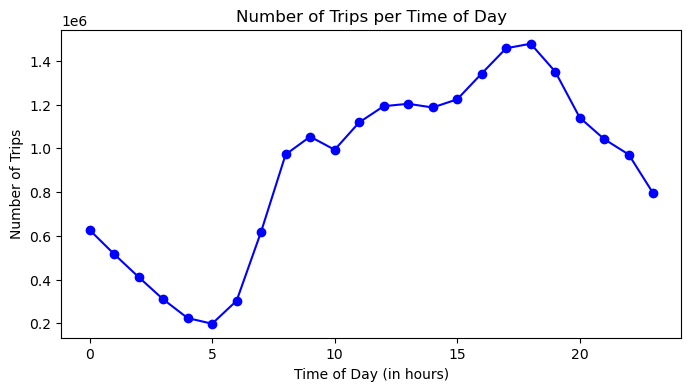

In [8]:
# hourly demand
plt.figure(figsize=(8,4))
plt.plot(time['Time_Period'],time['Trips'],'o-', color='blue')
plt.xlabel("Time of Day (in hours)")
plt.ylabel("Number of Trips")
plt.title("Number of Trips per Time of Day")
#plt.savefig("2_daily_demand.png")
plt.show()

### Usage during a Week

In [9]:
# number of trips for every day of a weak
weekdays =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_week=np.zeros(7)
for i in range(7):
    trips_week[i] = len(df[df["weekday"]==i])
    
weekdaysize = pd.DataFrame({'Weekday': weekdays, 'Trips': trips_week})
weekdaysize

,Weekday,Trips
0,Monday,2774671.0
1,Tuesday,3124166.0
2,Wednesday,3362848.0
3,Thursday,3542624.0
4,Friday,3610376.0
5,Saturday,2915637.0
6,Sunday,2406844.0


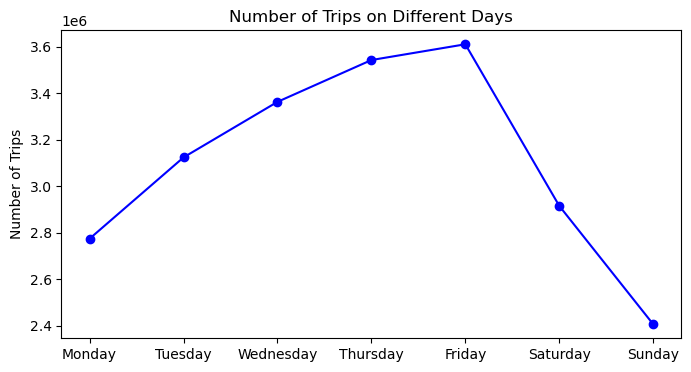

In [10]:
# weekly demand
plt.figure(figsize=(8,4))
plt.plot(weekdaysize["Weekday"], weekdaysize["Trips"],'o-', color='blue')
plt.ylabel("Number of Trips")
plt.title("Number of Trips on Different Days")
#plt.savefig("2_weekly_demand.png")
plt.show()

### Usage during a Year

In [11]:
months=["January","February","March","April","May","June","July","August","September","October","November","December"]

In [12]:
# number of trips for every month of the year
trips_month = np.zeros(12)
for i in range(12):
    trips_month[i]= len(df[df["month"]==i+1])

year= pd.DataFrame({'Months':months, 'Trips':trips_month})
year

,Months,Trips
0,January,1693112.0
1,February,1647777.0
2,March,2054348.0
3,April,1912549.0
4,May,2015806.0
5,June,2027055.0
6,July,1792559.0
7,August,1816699.0
8,September,1698700.0
9,October,1870099.0


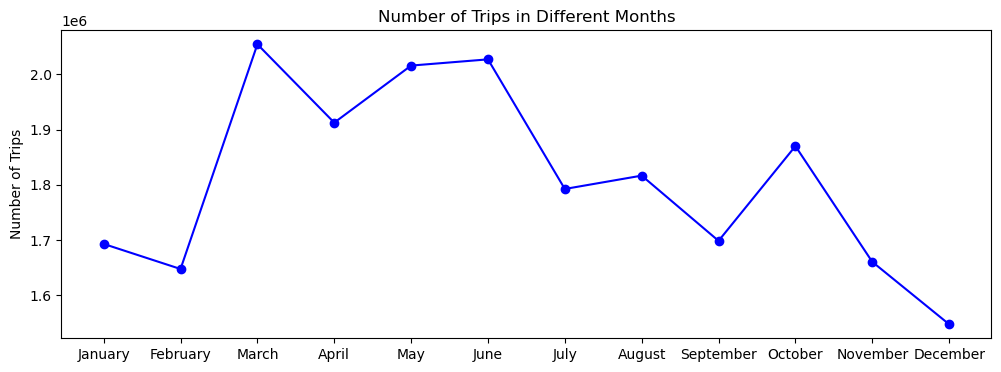

In [13]:
# yearly demand
plt.figure(figsize=(12,4))
plt.plot(year["Months"], year["Trips"],'o-', color='blue')
plt.ylabel("Number of Trips")
plt.title("Number of Trips in Different Months")
#plt.savefig("2_yearly_demand.png")
plt.show()

## Spatial Analysis

### Load Data and Data Overview

#### Taxi Trip Dataset

In [14]:
# Convert taxi_trips DataFrame to a GeoDataFrame
taxi_trips = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.start_longitude, df.start_latitude)
)
taxi_trips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21737166 entries, 0 to 21737165
Data columns (total 31 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   start_time                 datetime64[ns]
 1   end_time                   datetime64[ns]
 2   trip_seconds               float64       
 3   trip_miles                 float64       
 4   start_census               float64       
 5   end_census                 float64       
 6   start_community            int64         
 7   end_community              int64         
 8   fare                       float64       
 9   tips                       float64       
 10  tolls                      float64       
 11  extras                     float64       
 12  trip_total                 float64       
 13  payment_type               object        
 14  company                    object        
 15  start_latitude             float64       
 16  start_longitude           

#### Census Dataset

In [15]:
# census data from "extra files" for census bounderies
census=gpd.read_file('extra_dataframes/Census Tracts - 2010.geojson')
census.head(2)

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."


<Axes: >

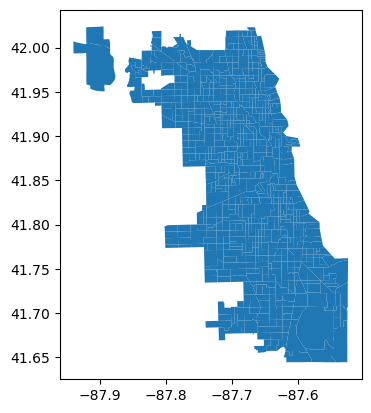

In [16]:
# Plot Census Tracts of Chicago
census.plot()

In [17]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   statefp10   801 non-null    object  
 1   name10      801 non-null    object  
 2   commarea_n  801 non-null    object  
 3   namelsad10  801 non-null    object  
 4   commarea    801 non-null    object  
 5   geoid10     801 non-null    object  
 6   notes       801 non-null    object  
 7   tractce10   801 non-null    object  
 8   countyfp10  801 non-null    object  
 9   geometry    801 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 62.7+ KB


#### New Dataframe for Census Analysis

In [18]:
# dataframe for census analysis with only census id and its geometry
census_analysis = census[['geoid10','geometry']]
census_analysis = census_analysis.rename(columns={'geoid10':'start_census'})
census_analysis['start_census'] = census_analysis['start_census'].astype('int64')
census_analysis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   start_census  801 non-null    int64   
 1   geometry      801 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 12.6 KB


#### New Dataframe for Hexagon Analysis

In [19]:
# Dataframe with only relevant spatial data for H3
h3_taxi_trips = taxi_trips[["start_latitude","start_longitude","end_latitude","end_longitude","trip_miles","trip_seconds","fare","hour","weekday"]]
h3_taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21737166 entries, 0 to 21737165
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   start_latitude   float64
 1   start_longitude  float64
 2   end_latitude     float64
 3   end_longitude    float64
 4   trip_miles       float64
 5   trip_seconds     float64
 6   fare             float64
 7   hour             int64  
 8   weekday          int64  
dtypes: float64(7), int64(2)
memory usage: 1.5 GB


In [20]:
# Set Hexagon Resolution
H3_HEXAGON_RESOLUTION = 5

h3_taxi_trips["h3_hex_id_start"] = h3_taxi_trips.apply(lambda row: h3.geo_to_h3(row["start_latitude"], row["start_longitude"], H3_HEXAGON_RESOLUTION) if (row['start_latitude'] and row['start_longitude']) else 0, axis=1)

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_16500\2058925653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h3_taxi_trips["h3_hex_id_start"] = h3_taxi_trips.apply(lambda row: h3.geo_to_h3(row["start_latitude"], row["start_longitude"], H3_HEXAGON_RESOLUTION) if (row['start_latitude'] and row['start_longitude']) else 0, axis=1)


In [21]:
h3_taxi_trips["h3_hex_id_end"] = h3_taxi_trips.apply(lambda row: h3.geo_to_h3(row["end_latitude"], row["end_longitude"], H3_HEXAGON_RESOLUTION) if (row['end_latitude'] and row['end_longitude']) else 0, axis=1)

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_16500\2065706388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h3_taxi_trips["h3_hex_id_end"] = h3_taxi_trips.apply(lambda row: h3.geo_to_h3(row["end_latitude"], row["end_longitude"], H3_HEXAGON_RESOLUTION) if (row['end_latitude'] and row['end_longitude']) else 0, axis=1)


In [22]:
h3_taxi_trips.reset_index(inplace=True)
h3_taxi_trips.head()

,index,start_latitude,start_longitude,end_latitude,end_longitude,trip_miles,trip_seconds,fare,hour,weekday,h3_hex_id_start,h3_hex_id_end
0,0,41.893216,-87.637844,41.892508,-87.626215,0.0,1800.0,13.25,0,6,852664c3fffffff,852664c3fffffff
1,1,42.001571,-87.695013,41.965812,-87.655879,2.7,660.0,10.00,0,6,852664dbfffffff,852664dbfffffff
2,2,41.953582,-87.723452,41.953582,-87.723452,0.5,120.0,4.50,0,6,852664cbfffffff,852664cbfffffff
3,3,41.880994,-87.632746,41.885281,-87.657233,1.3,240.0,6.25,0,6,852664c3fffffff,852664cbfffffff
4,4,41.879255,-87.642649,41.880994,-87.632746,0.0,420.0,6.00,0,6,852664c3fffffff,852664c3fffffff


#### Surface of Chicago

In [23]:
import json
city_bounding_box = gpd.read_file('extra_dataframes/Boundaries - City.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [24]:
city_bounding_box

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1,6450276623.31,845282.931362,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."


<Axes: >

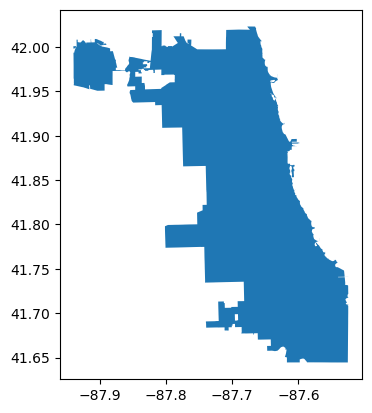

In [25]:
city_bounding_box.plot()

### Trip Length (in miles and seconds)

#### Per Census Tract in Miles

In [27]:
# Take mean of trip distance for each census tract
trip_distance = taxi_trips.groupby('start_census')['trip_miles'].mean()
trip_distance = pd.DataFrame(trip_distance) 

# Make index to column
trip_distance = trip_distance.reset_index()

trip_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_census  554 non-null    float64
 1   trip_miles    554 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


In [28]:
# Merge census data with dataframe containing the calculated mean distance for each census 
# (to get the surface for each tract even if there is no trip length data for it)
merged =census_analysis.merge(trip_distance, how = 'left', on='start_census')

census_analysis['trip_distance'] = merged['trip_miles']
census_analysis.head(3)

,start_census,geometry,trip_distance
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",0.818750
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",0.472977
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",2.797059


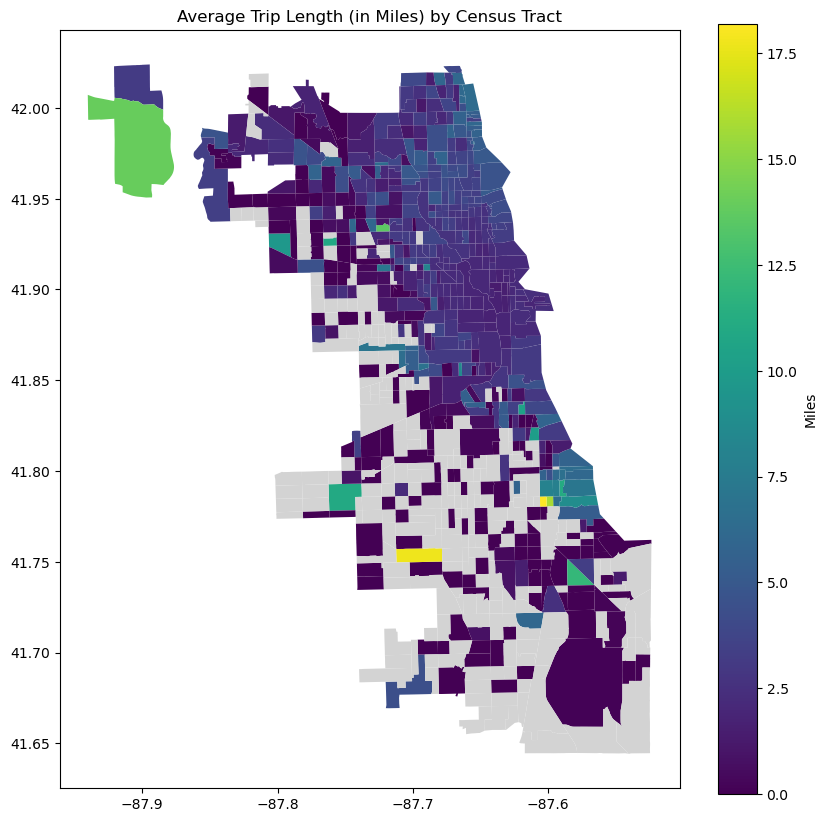

In [29]:
# Plot average trip length (in miles) for each start census tract
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='trip_distance', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Miles"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Length (in Miles) by Census Tract')
#plt.savefig("2_trip_dist_census.png")
plt.show()

#### Per Census Tract in Seconds

In [30]:
# Take mean of trip length for each census tract
trip_duration = taxi_trips.groupby('start_census')['trip_seconds'].mean()
trip_duration = pd.DataFrame(trip_duration) 

# Make index to column
trip_duration = trip_duration.reset_index()

trip_duration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_census  554 non-null    float64
 1   trip_seconds  554 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


In [31]:
# Merge census data with dataframe containing the calculated mean duration for each census 
# (to get the surface for each tract even if there is no trip duration data for it)
merged =census_analysis.merge(trip_duration, how = 'left', on='start_census')

census_analysis['trip_duration'] = merged['trip_seconds']
census_analysis.head(3)

,start_census,geometry,trip_distance,trip_duration
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",0.818750,121.000000
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",0.472977,190.778055
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",2.797059,778.414403


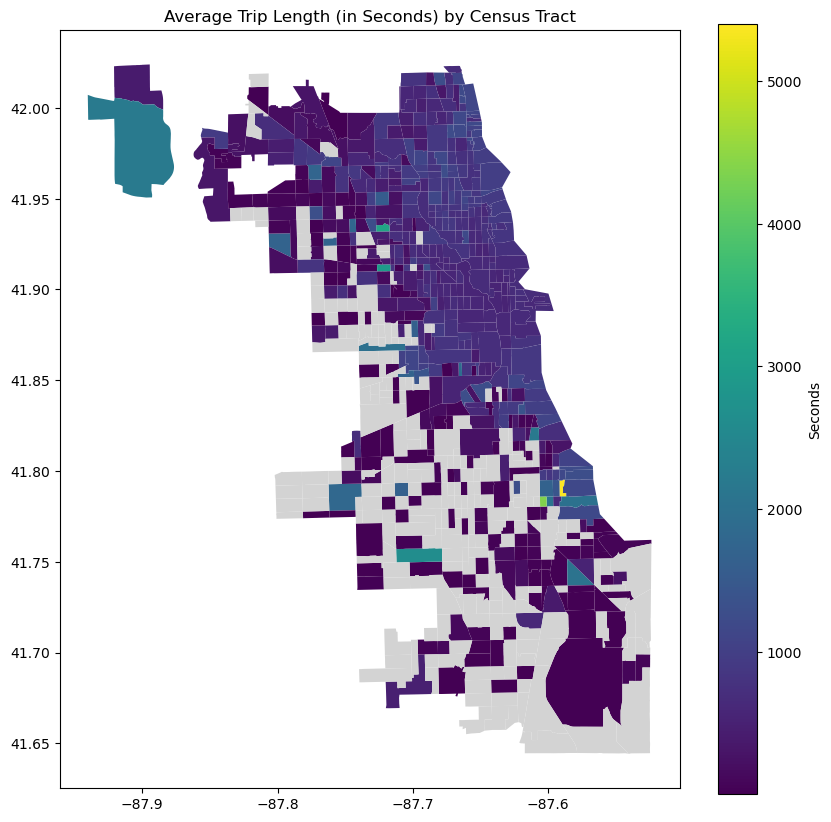

In [32]:
# Plot average trip length (in seconds) for each start census tract
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='trip_duration', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Seconds"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Length (in Seconds) by Census Tract')
#plt.savefig("2_trip_dur_census.png")
plt.show()

#### Per Hexagon in Miles

In [33]:
# Get mean trip distance per hexagon where trip started
trips_start_dist = pd.DataFrame()
trips_start_dist = h3_taxi_trips.groupby('h3_hex_id_start').mean()['trip_miles'].reset_index().rename(columns={'trip_miles': 'mean_trip_miles'})
# convert each 'h3_hex_id_start' value to the corresponding polygon boundary
trips_start_dist['geometry'] = trips_start_dist.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_start_dist_geo = gpd.GeoDataFrame(trips_start_dist, geometry=trips_start_dist['geometry'], crs='EPSG:4326')

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_16500\766504127.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips_start_dist = h3_taxi_trips.groupby('h3_hex_id_start').mean()['trip_miles'].reset_index().rename(columns={'trip_miles': 'mean_trip_miles'})


In [34]:
trips_start_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   h3_hex_id_start  8 non-null      object 
 1   mean_trip_miles  8 non-null      float64
 2   geometry         8 non-null      object 
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


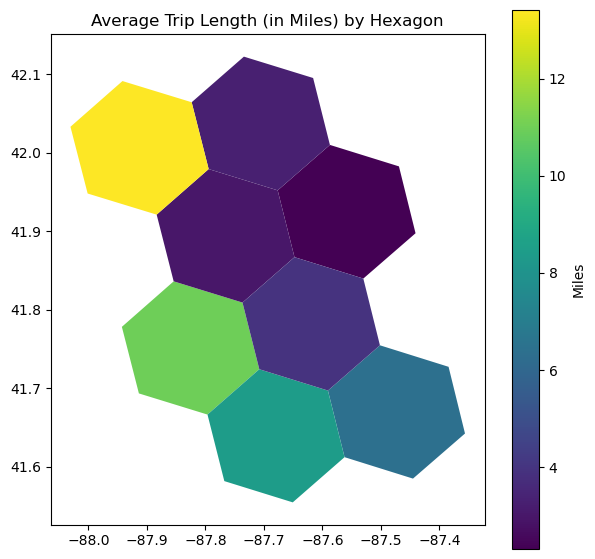

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_start_dist_geo.plot(column='mean_trip_miles', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Miles"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Length (in Miles) by Hexagon')
#plt.savefig("2_trip_dist_h3_8.png")
plt.show()

#### Per Hexagon in Seconds

In [36]:
# Get mean trip duration per hexagon where trip started
trips_start_dur = pd.DataFrame()
trips_start_dur = h3_taxi_trips.groupby('h3_hex_id_start').mean()['trip_seconds'].reset_index().rename(columns={'trip_seconds': 'mean_trip_seconds'})
trips_start_dur['geometry'] = trips_start_dur.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_start_dur_geo = gpd.GeoDataFrame(trips_start_dur, geometry=trips_start_dur['geometry'], crs='EPSG:4326')

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_16500\3444216376.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips_start_dur = h3_taxi_trips.groupby('h3_hex_id_start').mean()['trip_seconds'].reset_index().rename(columns={'trip_seconds': 'mean_trip_seconds'})


In [37]:
trips_start_dur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   h3_hex_id_start    8 non-null      object 
 1   mean_trip_seconds  8 non-null      float64
 2   geometry           8 non-null      object 
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


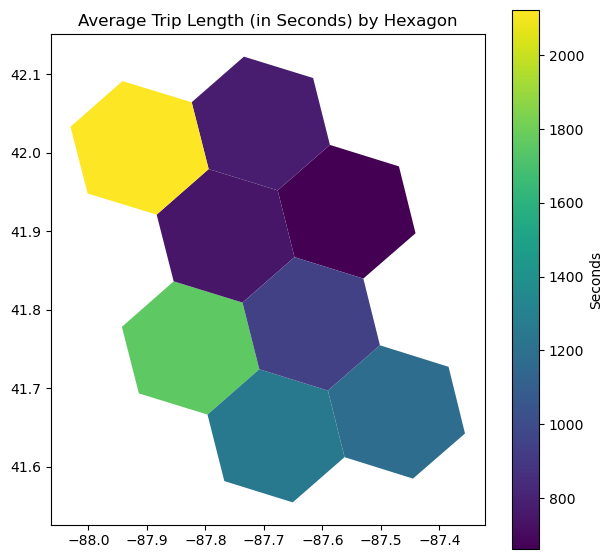

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_start_dur_geo.plot(column='mean_trip_seconds', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Seconds"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Length (in Seconds) by Hexagon')
#plt.savefig("2_trip_dur_h3_8.png")
plt.show()

### Price

#### Per Census Tract

In [39]:
# Take mean of fare for each census tract
trip_price = taxi_trips.groupby('start_census')['fare'].mean()
trip_price = pd.DataFrame(trip_price) 

# Make index to column
trip_price = trip_price.reset_index()

trip_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_census  554 non-null    float64
 1   fare          554 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


In [40]:
# Merge census data with dataframe containing the calculated mean fare for each census 
# (to get the surface for each tract even if there is no trip data for it)
merged =census_analysis.merge(trip_price, how = 'left', on='start_census')

census_analysis['trip_price'] = merged['fare']
census_analysis.head(3)

,start_census,geometry,trip_distance,trip_duration,trip_price
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",0.818750,121.000000,5.143750
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",0.472977,190.778055,4.627284
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",2.797059,778.414403,11.881591


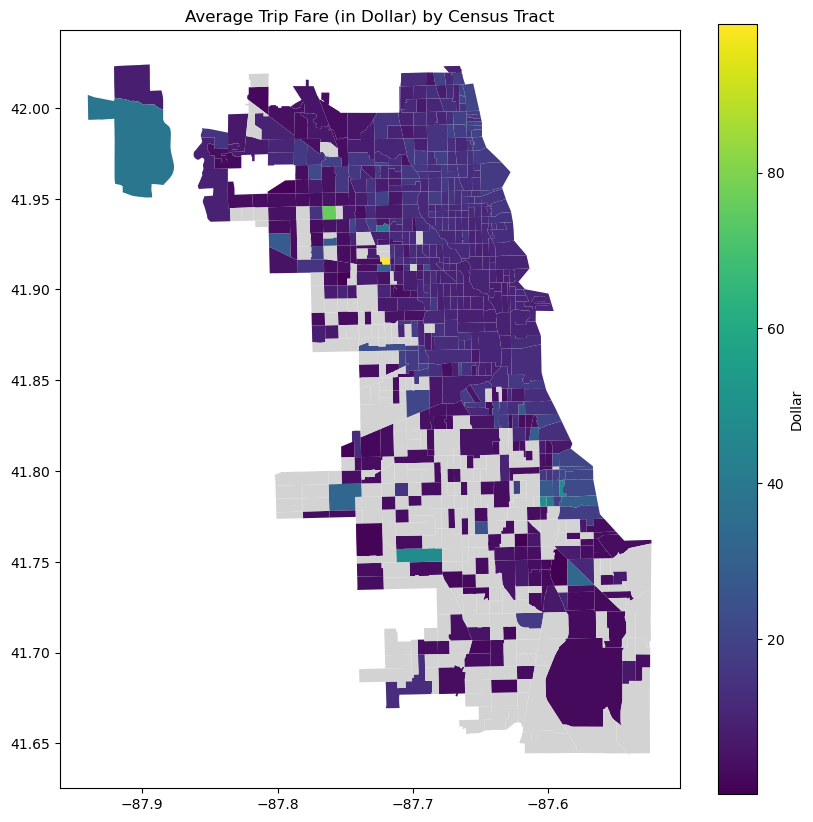

In [41]:
# Plot average trip price (in dollar) for each start census tract
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='trip_price', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Dollar"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Fare (in Dollar) by Census Tract')
#plt.savefig("2_trip_price_census.png")
plt.show()

#### Per Hexagon

In [42]:
# Get mean fare of trip per hexagon where trip started
trips_start_fare = pd.DataFrame()
trips_start_fare = h3_taxi_trips.groupby('h3_hex_id_start').mean()['fare'].reset_index().rename(columns={'fare': 'mean_fare'})
trips_start_fare['geometry'] = trips_start_fare.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_start_fare_geo = gpd.GeoDataFrame(trips_start_fare, geometry=trips_start_fare['geometry'], crs='EPSG:4326')

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_16500\778739744.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips_start_fare = h3_taxi_trips.groupby('h3_hex_id_start').mean()['fare'].reset_index().rename(columns={'fare': 'mean_fare'})


In [43]:
trips_start_fare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   h3_hex_id_start  8 non-null      object 
 1   mean_fare        8 non-null      float64
 2   geometry         8 non-null      object 
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


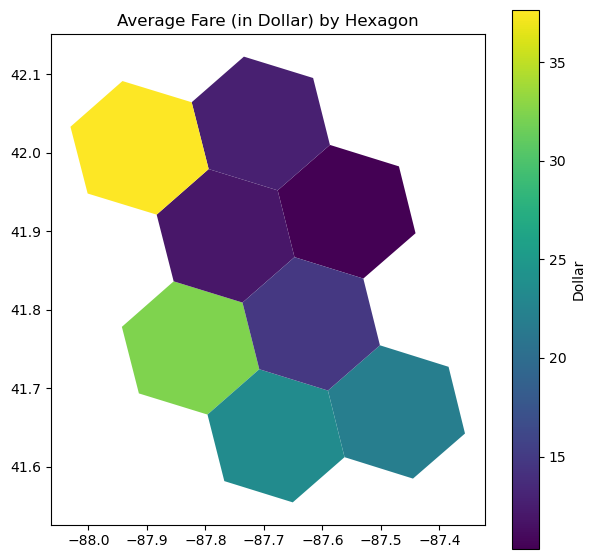

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_start_fare_geo.plot(column='mean_fare', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Dollar"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Fare (in Dollar) by Hexagon')
#plt.savefig("2_trip_price_h3_8.png")
plt.show()

### Start and End Location

#### Per Census Tract

In [45]:
# Count how many trips start and end in each census tract
start_census_count = taxi_trips.groupby('start_census')['start_census'].count()
start_census_count = pd.DataFrame(start_census_count)
end_census_count = taxi_trips.groupby('end_census')['end_census'].count()
end_census_count = pd.DataFrame(end_census_count)

# Rename the column to make index to new column (otherwise not possible because of same name)
start_census_count = start_census_count.rename(columns={"start_census": "start_census_counts"})
start_census_count = start_census_count.reset_index()
end_census_count = end_census_count.rename(columns={"end_census": "end_census_counts"})
end_census_count = end_census_count.reset_index()
# Rename end to start to facilitate the merge
end_census_count = end_census_count.rename(columns={"end_census": "start_census"})

start_census_count.info()
end_census_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_census         554 non-null    float64
 1   start_census_counts  554 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 8.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_census       653 non-null    float64
 1   end_census_counts  653 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 10.3 KB


In [46]:
# Merge census data with dataframe containing the number of trips for each census 
# (to get the surface for each tract even if there is no trip length data for it)
merged_start = census_analysis.merge(start_census_count, how = 'left', on='start_census')
merged_start.info()
merged_end =census_analysis.merge(end_census_count, how = 'left', on='start_census')
merged_end.info()

census_analysis['start_census_counts'] = merged_start['start_census_counts']
census_analysis['end_census_counts'] = merged_end['end_census_counts']

census_analysis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   start_census         801 non-null    int64   
 1   geometry             801 non-null    geometry
 2   trip_distance        553 non-null    float64 
 3   trip_duration        553 non-null    float64 
 4   trip_price           553 non-null    float64 
 5   start_census_counts  553 non-null    float64 
dtypes: float64(4), geometry(1), int64(1)
memory usage: 43.8 KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   start_census       801 non-null    int64   
 1   geometry           801 non-null    geometry
 2   trip_distance      553 non-null    float64 
 3   trip_duration      553 non-null    float64 
 4   trip_

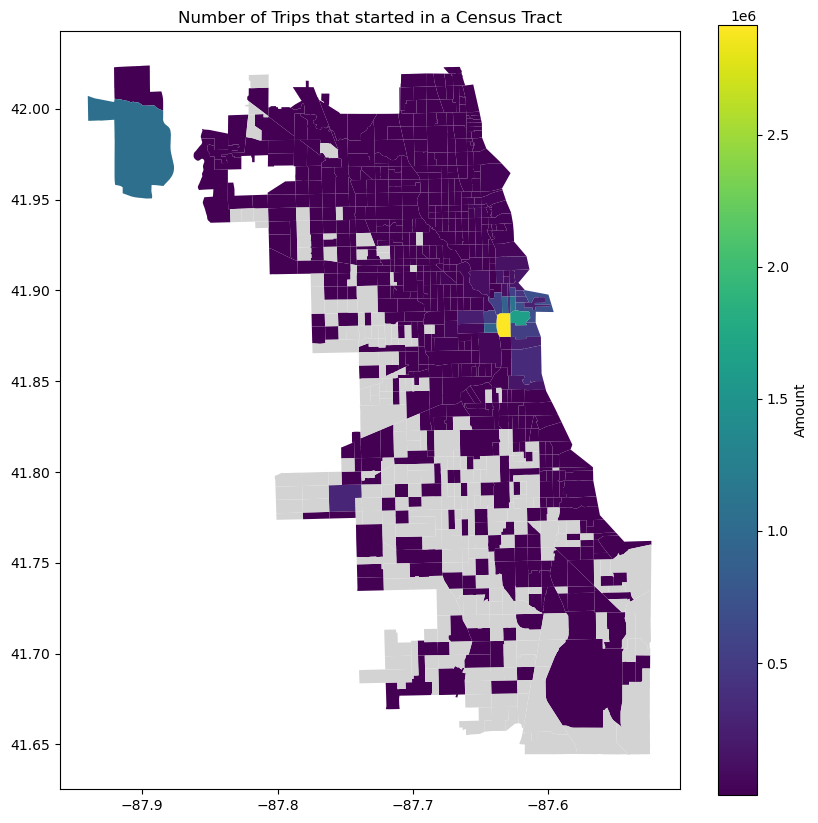

In [47]:
# Plot number of started trips for each census tract
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='start_census_counts', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that started in a Census Tract')
#plt.savefig("2_trip_start_census.png")
plt.show()

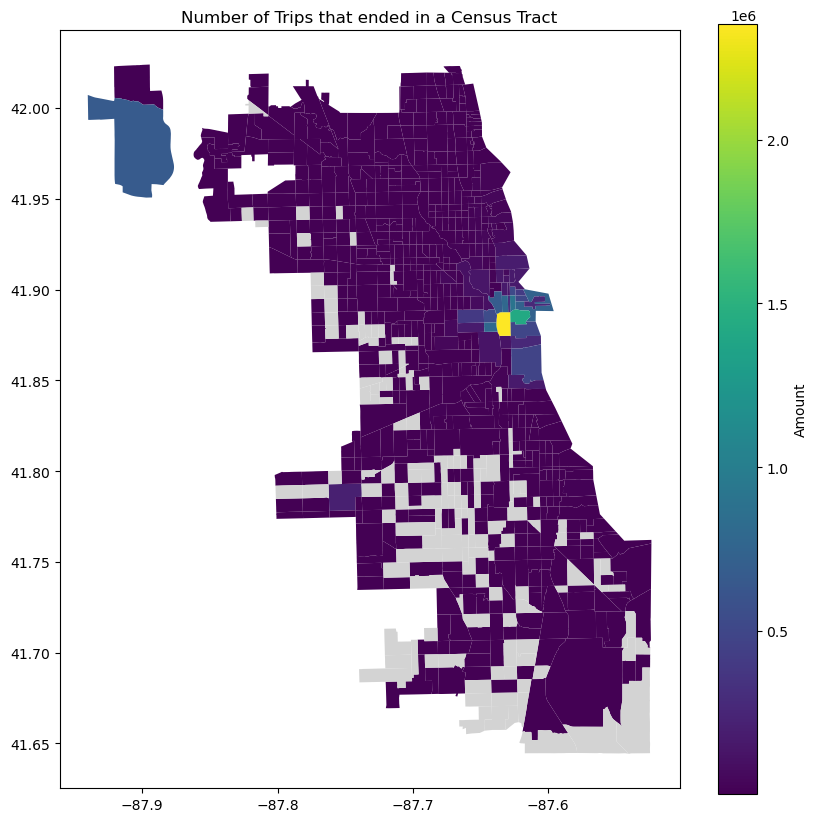

In [48]:
# Plot number of ending trips for each census tract
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='end_census_counts', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that ended in a Census Tract')
#plt.savefig("2_trip_end_census.png")
plt.show()

#### Per Hexagon

In [49]:
trips_start_count = pd.DataFrame()
trips_start_count = h3_taxi_trips.groupby('h3_hex_id_start').count()['index'].reset_index().rename(columns={'index': 'count_start'})
trips_start_count['geometry'] = trips_start_count.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_start_count_geo = gpd.GeoDataFrame(trips_start_count, geometry=trips_start_count['geometry'], crs='EPSG:4326')

In [50]:
trips_start_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   h3_hex_id_start  8 non-null      object
 1   count_start      8 non-null      int64 
 2   geometry         8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


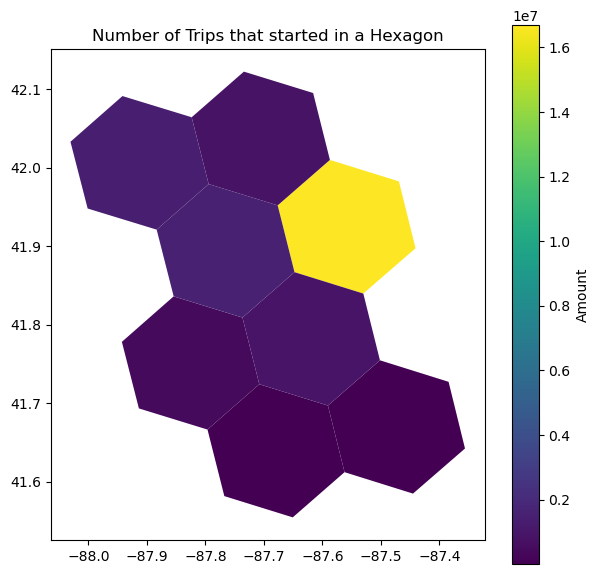

In [51]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_start_count_geo.plot(column='count_start', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that started in a Hexagon')
#plt.savefig("2_trip_start_h3_8.png")
plt.show()

In [52]:
trips_end_count = pd.DataFrame()
trips_end_count = h3_taxi_trips.groupby('h3_hex_id_end').count()['index'].reset_index().rename(columns={'index': 'count_end'})
trips_end_count['geometry'] = trips_end_count.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_end"], geo_json=True)), axis=1)

trips_end_count_geo = gpd.GeoDataFrame(trips_end_count, geometry=trips_end_count['geometry'], crs='EPSG:4326')

In [53]:
trips_end_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   h3_hex_id_end  8 non-null      object
 1   count_end      8 non-null      int64 
 2   geometry       8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


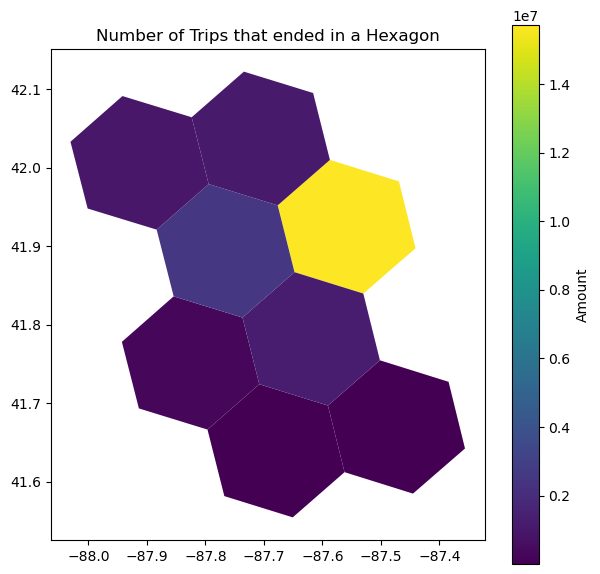

In [54]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_end_count_geo.plot(column='count_end', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that ended in a Hexagon')
#plt.savefig("2_trip_end_h3_8.png")
plt.show()

### Start Time

#### Per Census Tract

In [55]:
# Dataframe with only the hour, the weekday and the start and end census
little_taxi_trips = taxi_trips[["start_census","end_census","hour", "weekday"]]
little_taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21737166 entries, 0 to 21737165
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   start_census  float64
 1   end_census    float64
 2   hour          int64  
 3   weekday       int64  
dtypes: float64(2), int64(2)
memory usage: 663.4 MB


In [56]:
# For Rushhour in the evening (4 pm to 8 pm ) run code with this 
#filtered_taxi_trips = little_taxi_trips[(little_taxi_trips["hour"] > 15) & (little_taxi_trips["hour"] < 21) & (little_taxi_trips["weekday"] < 5)]


# Filter dataframe to only include trips between 5 am and 9 am (rushhour) during the week
filtered_taxi_trips = little_taxi_trips[(little_taxi_trips["hour"] > 4) & (little_taxi_trips["hour"] < 10) & (little_taxi_trips["weekday"] < 5)]
filtered_taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708880 entries, 54998 to 21637166
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   start_census  float64
 1   end_census    float64
 2   hour          int64  
 3   weekday       int64  
dtypes: float64(2), int64(2)
memory usage: 103.3 MB


In [57]:
# Count how many trips start and end in each census tract in the given time interval
start_census_count_morning = filtered_taxi_trips.groupby('start_census')['start_census'].count()
start_census_count_morning = pd.DataFrame(start_census_count_morning)
end_census_count_morning = filtered_taxi_trips.groupby('end_census')['end_census'].count()
end_census_count_morning = pd.DataFrame(end_census_count_morning)

# Rename the column to make index to new column (otherwise not possible because of same name)
start_census_count_morning = start_census_count_morning.rename(columns={"start_census": "start_census_counts_m"})
start_census_count_morning = start_census_count_morning.reset_index()
end_census_count_morning = end_census_count_morning.rename(columns={"end_census": "end_census_counts_m"})
end_census_count_morning = end_census_count_morning.reset_index()
end_census_count_morning = end_census_count_morning.rename(columns={"end_census": "start_census"})

start_census_count_morning.info()
end_census_count_morning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   start_census           361 non-null    float64
 1   start_census_counts_m  361 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 5.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_census         387 non-null    float64
 1   end_census_counts_m  387 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 6.2 KB


In [58]:
# Merge census data with dataframe containing the number of trips for each census 
# (to get the surface for each tract even if there is no trip length data for it)
merged_start_morning =census_analysis.merge(start_census_count_morning, how = 'left', on='start_census')
merged_start_morning.info()
merged_end_morning =census_analysis.merge(end_census_count_morning, how = 'left', on='start_census')
merged_end_morning.info()

census_analysis['start_census_counts_morning'] = merged_start_morning['start_census_counts_m']
census_analysis['end_census_counts_morning'] = merged_end_morning['end_census_counts_m']

census_analysis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   start_census           801 non-null    int64   
 1   geometry               801 non-null    geometry
 2   trip_distance          553 non-null    float64 
 3   trip_duration          553 non-null    float64 
 4   trip_price             553 non-null    float64 
 5   start_census_counts    553 non-null    float64 
 6   end_census_counts      652 non-null    float64 
 7   start_census_counts_m  360 non-null    float64 
dtypes: float64(6), geometry(1), int64(1)
memory usage: 56.3 KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   start_census         801 non-null    int64   
 1   geometry             801

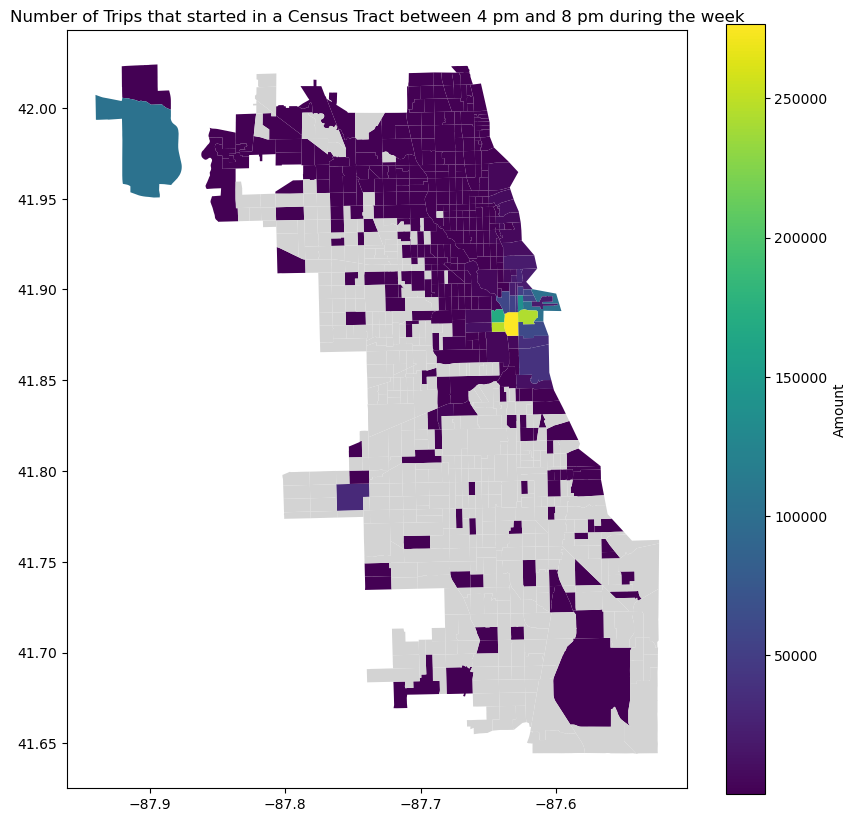

In [59]:
# Plot number of started trips for each census tract in the morning rushhours or evening rushhours
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='start_census_counts_morning', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that started in a Census Tract between 4 pm and 8 pm during the week')
#plt.savefig("2_trip_ev_rush_census.png")
plt.show()

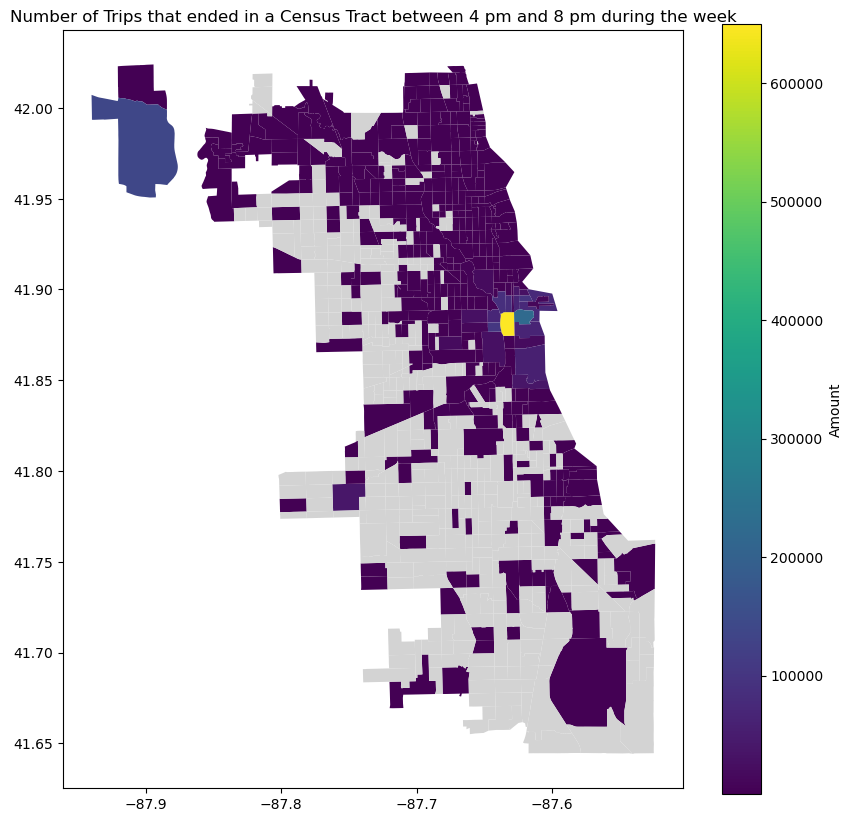

In [60]:
# Plot number of started trips for each census tract in the morning rushhours
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='end_census_counts_morning', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that ended in a Census Tract between 4 pm and 8 pm during the week')
#plt.savefig("2_trip_ev_rush_end_census.png")
plt.show()

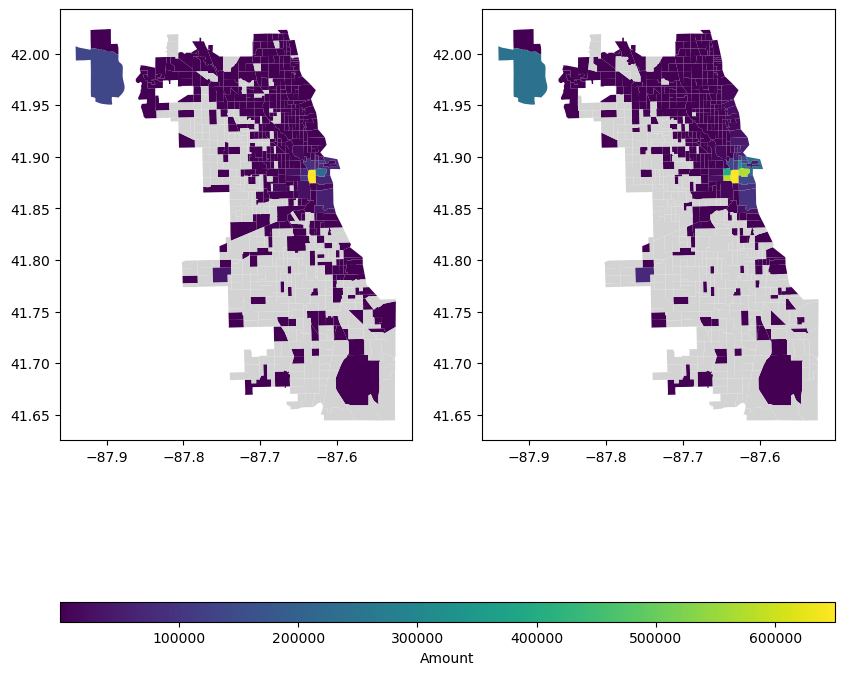

In [61]:
# Create a figure with a grid layout to compare the start and end census tracts
fig = plt.figure(figsize=(10, 10))
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1, 1], height_ratios=[15, 0.4])

# Plot number of trips that started in each census tract in the morning rush hours
ax2 = fig.add_subplot(grid[0, 1])
start_census_plot = census_analysis.plot(column='start_census_counts_morning', cmap='viridis', linewidth=0.8, ax=ax2, legend=False, missing_kwds={'color': 'lightgrey'})
#ax2.set_title('Number of Trips that started in a Census Tract between 5 am and 9 am during the week')

# Plot number of trips that ended in each census tract in the morning rush hours
ax1 = fig.add_subplot(grid[0, 0])
end_census_plot = census_analysis.plot(column='end_census_counts_morning', cmap='viridis', linewidth=0.8, ax=ax1, legend=False, missing_kwds={'color': 'lightgrey'})
#ax1.set_title('Number of Trips that ended in a Census Tract between 5 am and 9 am during the week')

# Create a colorbar
cax = fig.add_subplot(grid[1, :])
cmap = plt.cm.viridis
norm = colors.Normalize(vmin=min(census_analysis['start_census_counts_morning'].min(), census_analysis['end_census_counts_morning'].min()), vmax=max(census_analysis['start_census_counts_morning'].max(), census_analysis['end_census_counts_morning'].max()))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Amount')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.01)

#plt.savefig("2_trip_ev_rush_both_census.png")

# Display the plot
plt.show()

#### Per Hexagon

In [62]:
# For Rushhour in the evening (4 pm to 8 pm) run code with this 
#filtered_h3_taxi_trips = h3_taxi_trips[(h3_taxi_trips["hour"] > 15) & (h3_taxi_trips["hour"] < 21) & (h3_taxi_trips["weekday"] < 5)]


# Filter dataframe to only include trips between 5 am and 9 am (rushhour) during the week
filtered_h3_taxi_trips = h3_taxi_trips[(h3_taxi_trips["hour"] > 4) & (h3_taxi_trips["hour"] < 10) & (h3_taxi_trips["weekday"] < 5)]

filtered_h3_taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708880 entries, 54998 to 21637166
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   index            int64  
 1   start_latitude   float64
 2   start_longitude  float64
 3   end_latitude     float64
 4   end_longitude    float64
 5   trip_miles       float64
 6   trip_seconds     float64
 7   fare             float64
 8   hour             int64  
 9   weekday          int64  
 10  h3_hex_id_start  object 
 11  h3_hex_id_end    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 268.7+ MB


In [63]:
# For Start Hexagon
trips_start_count_m = pd.DataFrame()
trips_start_count_m = filtered_h3_taxi_trips.groupby('h3_hex_id_start').count()['index'].reset_index().rename(columns={'index': 'count_start_m'})
trips_start_count_m['geometry'] = trips_start_count.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_start_count_m_geo = gpd.GeoDataFrame(trips_start_count_m, geometry=trips_start_count_m['geometry'], crs='EPSG:4326')

In [64]:
trips_start_count_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   h3_hex_id_start  8 non-null      object
 1   count_start_m    8 non-null      int64 
 2   geometry         8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


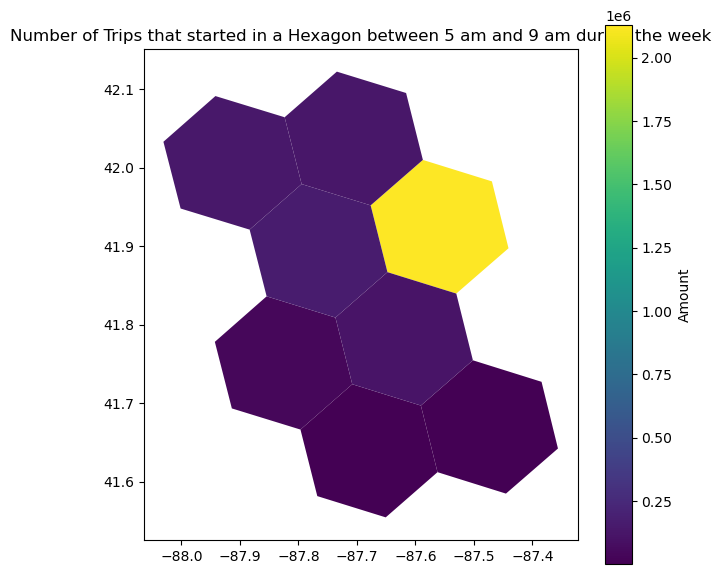

In [65]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_start_count_m_geo.plot(column='count_start_m', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that started in a Hexagon between 5 am and 9 am during the week')
#plt.savefig("2_trip_mo_rush_h3_5.png")
plt.show()

In [66]:
# For End Hexagon
trips_end_count_m = pd.DataFrame()
trips_end_count_m = filtered_h3_taxi_trips.groupby('h3_hex_id_end').count()['index'].reset_index().rename(columns={'index': 'count_end_m'})
trips_end_count_m['geometry'] = trips_end_count.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_end"], geo_json=True)), axis=1)

trips_end_count_m_geo = gpd.GeoDataFrame(trips_end_count_m, geometry=trips_end_count_m['geometry'], crs='EPSG:4326')

In [67]:
trips_end_count_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   h3_hex_id_end  8 non-null      object
 1   count_end_m    8 non-null      int64 
 2   geometry       8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


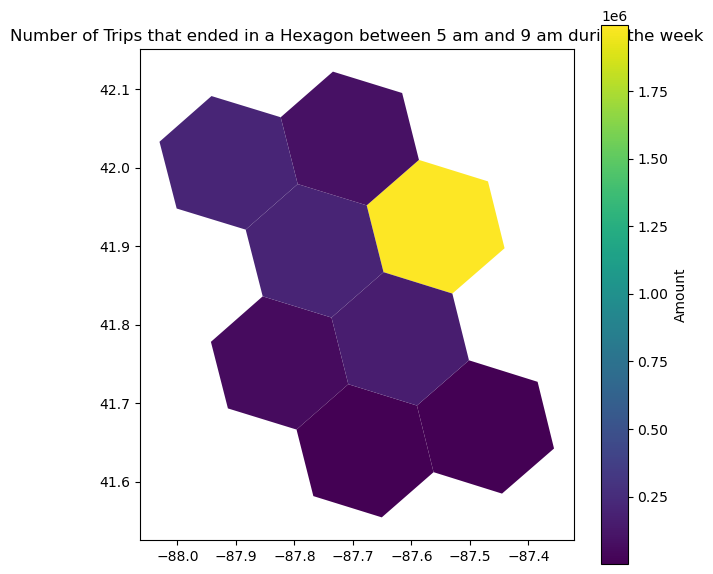

In [68]:
fig, ax = plt.subplots(figsize=(7, 7))
trips_end_count_m_geo.plot(column='count_end_m', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Amount"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Number of Trips that ended in a Hexagon between 5 am and 9 am during the week')
#plt.savefig("2_trip_mo_rush_end_h3_5.png")
plt.show()